## Importation

In [1]:
import pandas as pd
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Similar to Assignment 1, making a root path to the GitHub repository, then creating paths from there into the dataset folder, and to the attrition dataset file we will be cleaning.

In [2]:
import tarfile
import urllib

dir_path = "https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/HR_Analytics/main/"
data_path = os.path.join(dir_path, "data")
original_file_path = os.path.join(data_path, "hr_attrition.csv")

In [3]:
df = pd.read_csv(original_file_path)
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## Output Function

**This output is the culmination of the entire notebook**<br>
It's placed up here for convenience

This custom function takes in the dataset, then returns the cleaned version as well as an array containing the original values for the two label encoded variables - `JobRole` and `EducationField`

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


def transform(data):
    # first dropping the unnecessary columns
    data = data.drop(['EmployeeCount', 'StandardHours', 'Over18'], axis = 'columns')
    
    # categorizing features
    ohe_vars = ['Department', 'Gender', 'MaritalStatus', 'OverTime']
    ordinal_vars = ['BusinessTravel', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']
    lab_vars = ['EducationField', 'JobRole']
    
    # filtering the data to exclude outliers in the YearsAtCompany and TotalWorkingYears variables
    data = data[data['YearsAtCompany'] < 30]
    data = data[data['TotalWorkingYears'] < 30]
    
    # giving the original values for education field and job role to be used later, if needed
    inverse_edu_job = data[lab_vars]
    
    df_num = [] # list of numerical variables
    cat_vars = ordinal_vars + ohe_vars + lab_vars
    cat_vars.append('Attrition') # target variable
    for i in list(data.columns):
        if i not in cat_vars:
            df_num.append(i)
    
    # ordinal encoding of the ordinal variables
    if type(data['BusinessTravel'][0]) == str:
        data['BusinessTravel'] = data['BusinessTravel'].replace({'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2})
    ord_pipeline = Pipeline([('ord_enc', OrdinalEncoder())])
    data[ordinal_vars] = ord_pipeline.fit_transform(data[ordinal_vars])

    # label encoding the education field and job role
    lbl_edu = LabelEncoder()
    edu_encoded = lbl_edu.fit_transform(data[['EducationField']])
    lbl_job = LabelEncoder()
    job_encoded = lbl_job.fit_transform(data[['JobRole']])
    data['EducationField'] = edu_encoded
    data['JobRole'] = job_encoded

    
    # standardizing numerical variables
    num_pipeline = Pipeline([('scaler', StandardScaler())])
    num_std = num_pipeline.fit_transform(data[df_num])
    data[df_num] = num_std
    
    # using pd.get_dummies in lieu of OneHotEncoder
    data = pd.concat([data, pd.get_dummies(data[ohe_vars], drop_first = True)], axis = 'columns')
    data = data.drop(ohe_vars, axis = 1)
    
    if type(data['Attrition'][0]) == str:
        data['Attrition'] = data['Attrition'].replace({'Yes': 1, 'No': 0})
    
    return data, inverse_edu_job

In [5]:
df_transformed, inverse_array = transform(df)
df_transformed.head()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,...,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Research & Development,Department_Sales,Gender_Male,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,0.544150,1,1.0,0.736047,-1.017625,1.0,1,-1.697374,1.0,1.381722,...,-0.114763,-0.033885,-0.677222,0.278787,0,1,0,0,1,1
1,1.467991,0,2.0,-1.303969,-0.151871,0.0,1,-1.695721,2.0,-0.243010,...,0.630342,0.808486,-0.352586,0.850069,1,0,1,1,0,0
2,0.082230,1,1.0,1.407790,-0.893946,1.0,4,-1.692414,3.0,1.283253,...,-1.232420,-1.157047,-0.677222,-1.149417,1,0,1,0,1,1
3,-0.379691,0,2.0,1.454886,-0.770267,3.0,1,-1.690760,3.0,-0.489181,...,0.257789,0.808486,0.296686,-1.149417,1,0,0,1,0,1
4,-1.072571,0,1.0,-0.530597,-0.893946,0.0,3,-1.687454,0.0,-1.276930,...,-0.859867,-0.595466,-0.027950,-0.578135,1,0,1,1,0,0


In [8]:
inverse_array

,EducationField,JobRole
0,Life Sciences,Sales Executive
1,Life Sciences,Research Scientist
2,Other,Laboratory Technician
3,Life Sciences,Research Scientist
4,Medical,Laboratory Technician
...,...,...
1465,Medical,Laboratory Technician
1466,Medical,Healthcare Representative
1467,Life Sciences,Manufacturing Director
1468,Medical,Sales Executive


----

## Some General Exploration

In [9]:
df.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

No null values in this dataset - no need for imputation, then

References for some of the categorical variables with different values:<br>
- `Education`:
    - 1: Below College
    - 2: College
    - 3: Bachelor
    - 4: Master
    - 5: Doctor
- `EnvironmentSatisfaction`:
    - 1: Low
    - 2: Medium
    - 3: High
    - 4: Very High
- `JobInvolvement`:
    - 1: Low
    - 2: Medium
    - 3: High
    - 4: Very High
- `JobSatisfaction`:
    - 1: Low
    - 2: Medium
    - 3: High
    - 4: Very High
- `PerformanceRating`:
    - 1: Low
    - 2: Good
    - 3: Excellent
    - 4: Outstanding
- `RelationshipSatisfaction`:
    - 1: Low
    - 2: Medium
    - 3: High
    - 4: Very High
- `WorkLifeBalance`:
    - 1: Bad
    - 2: Good
    - 3: Better
    - 4: Best

In [10]:
df.describe()[df.describe().columns[:9]]

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000


In [11]:
df.describe()[df.describe().columns[9:17]]

,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245
std,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209
min,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000
25%,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000
50%,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000
75%,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000
max,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000


In [12]:
df.describe()[df.describe().columns[17:]]

,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


Right away, we can see that `StandardHours` and `EmployeeCount` have been standardized to a uniform level. We can drop these without losing any information.

In [13]:
df = df.drop(['EmployeeCount', 'StandardHours'], axis = 'columns')

Some of the variables are clearly categorical, but were not given descriptions in the data dictionary. A list of all the numerical variables which appear categorical is as follows:
- `Education`
- `EnvironmentSatisfaction`
- `JobInvolvement`
- `JobLevel`
- `JobSatisfaction`
- `PerformanceRating`
- `RelationshipSatisfaction`
- `StockOptionLevel`
- `WorkLifeBalance`

Each of these variables seem to be ordinal (higher number is better). Ordinal Encoding can be used on these.

#### Non-numeric Columns

In [14]:
# listing the variables not included in the describe() function - not numerical
desc_cols = list(df.describe().columns)
df_cols = list(df.columns)

df[list(np.setdiff1d(df_cols, desc_cols))]

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
0,Yes,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single,Y,Yes
1,No,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Married,Y,No
2,Yes,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single,Y,Yes
3,No,Travel_Frequently,Research & Development,Life Sciences,Female,Research Scientist,Married,Y,Yes
4,No,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Married,Y,No
...,...,...,...,...,...,...,...,...,...
1465,No,Travel_Frequently,Research & Development,Medical,Male,Laboratory Technician,Married,Y,No
1466,No,Travel_Rarely,Research & Development,Medical,Male,Healthcare Representative,Married,Y,No
1467,No,Travel_Rarely,Research & Development,Life Sciences,Male,Manufacturing Director,Married,Y,Yes
1468,No,Travel_Frequently,Sales,Medical,Male,Sales Executive,Married,Y,No


In [15]:
df['Over18'].value_counts()

Y    1470
Name: Over18, dtype: int64

In [16]:
# dropping Over18 - useless variable here
df = df.drop('Over18', axis = 'columns')

In [17]:
df['BusinessTravel'].value_counts()

Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: BusinessTravel, dtype: int64

In [18]:
df['Department'].value_counts()

Research & Development    961
Sales                     446
Human Resources            63
Name: Department, dtype: int64

In [19]:
df['EducationField'].value_counts()

Life Sciences       606
Medical             464
Marketing           159
Technical Degree    132
Other                82
Human Resources      27
Name: EducationField, dtype: int64

In [20]:
df['Gender'].value_counts()

Male      882
Female    588
Name: Gender, dtype: int64

In [21]:
df['JobRole'].value_counts()

Sales Executive              326
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    131
Manager                      102
Sales Representative          83
Research Director             80
Human Resources               52
Name: JobRole, dtype: int64

In [22]:
df['MaritalStatus'].value_counts()

Married     673
Single      470
Divorced    327
Name: MaritalStatus, dtype: int64

In [23]:
df['OverTime'].value_counts()

No     1054
Yes     416
Name: OverTime, dtype: int64

#### Histogram of all numerical variables

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matpl

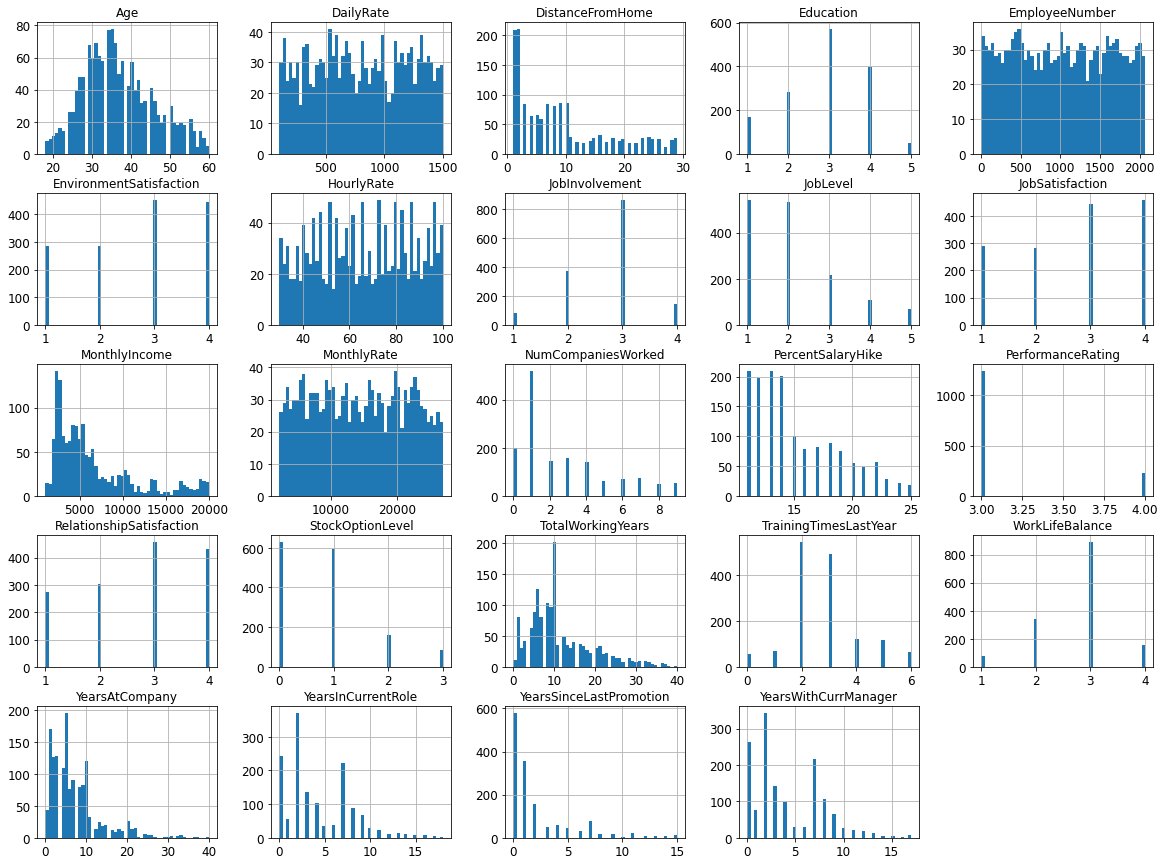

In [24]:
df.hist(bins=50, figsize=(20,15))
plt.show()

## Encoding Variables

The first hurdle in preparing this dataset is going to be encoding all the categorical variables. There are a number of variables which can be encoded ordinally (namely the numerical ones above). Others cannot be, and may need to be dealt with using other methods (like one hot or label encoding).

#### Ordinal Encoding

In [25]:
# variables which can be dealt with using ordinal encoding
ordinal_vars = ['BusinessTravel', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']
# business travel is currently input as a string array - changing to numerical values
df['BusinessTravel'] = df['BusinessTravel'].replace('Non-Travel', 0)
df['BusinessTravel'] = df['BusinessTravel'].replace('Travel_Rarely', 1)
df['BusinessTravel'] = df['BusinessTravel'].replace('Travel_Frequently', 2)

In [26]:
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
ordinal_vars_encoded = ord_enc.fit_transform(df[ordinal_vars])
ordinal_vars_encoded[:5]

array([[1., 1., 1., 2., 1., 3., 0., 0., 0., 0.],
       [2., 0., 2., 1., 1., 1., 1., 3., 1., 2.],
       [1., 1., 3., 1., 0., 2., 0., 1., 0., 2.],
       [2., 3., 3., 2., 0., 2., 0., 2., 0., 2.],
       [1., 0., 0., 2., 0., 1., 0., 3., 1., 2.]])

Next up is to deal with categorical variables which are not ordinal. The list of these such variables is as follows:
- `Attrition` (**Target Variable**)
- `Department`
- `EducationField`
- `Gender`
- `JobRole`
- `MaritalStatus`
- `OverTime`

In [27]:
other_vars = ['Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
# number of unique values in each of these fields
for i in other_vars:
    print(i + ": " + str(df[i].nunique()))

Department: 3
EducationField: 6
Gender: 2
JobRole: 9
MaritalStatus: 3
OverTime: 2


#### One Hot Encoding

Department, gender, marital status, and overtime can use one hot encoding since there are very few unique values in those categories. <br>
Education field and job role should use label encoding since they are high cardinality nominal data fields.

In [28]:
ohe_vars = ['Department', 'Gender', 'MaritalStatus', 'OverTime']

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
ohe_vars_encoded = ohe.fit_transform(df[ohe_vars])
ohe_vars_encoded = ohe_vars_encoded.toarray()
ohe_vars_encoded[:5]

array([[0., 0., 1., 1., 0., 0., 0., 1., 0., 1.],
       [0., 1., 0., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 1., 0., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0., 0., 1., 0., 0., 1.],
       [0., 1., 0., 0., 1., 0., 1., 0., 1., 0.]])

In [29]:
ohe.categories_

[array(['Human Resources', 'Research & Development', 'Sales'], dtype=object),
 array(['Female', 'Male'], dtype=object),
 array(['Divorced', 'Married', 'Single'], dtype=object),
 array(['No', 'Yes'], dtype=object)]

#### Label Encoding

In [30]:
# label encoding
lab_vars = ['EducationField', 'JobRole']
from sklearn.preprocessing import LabelEncoder
lbl_edu = LabelEncoder()
edu_encoded = lbl_edu.fit_transform(df[['EducationField']])

lbl_job = LabelEncoder()
job_encoded = lbl_job.fit_transform(df[['JobRole']])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [31]:
df_test = df.copy()
df_test.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,1,1102,Sales,1,2,Life Sciences,1,2,...,3,1,0,8,0,1,6,4,0,5
1,49,No,2,279,Research & Development,8,1,Life Sciences,2,3,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,1,1373,Research & Development,2,2,Other,4,4,...,3,2,0,7,3,3,0,0,0,0
3,33,No,2,1392,Research & Development,3,4,Life Sciences,5,4,...,3,3,0,8,3,3,8,7,3,0
4,27,No,1,591,Research & Development,2,1,Medical,7,1,...,3,4,1,6,3,3,2,2,2,2


In [32]:
df_test = pd.concat([df_test, pd.get_dummies(df_test[ohe_vars], drop_first = True)], axis = 'columns') #easier than sklearn OHE
df_test = df_test.drop(ohe_vars, axis = 1)
df_test['EducationField'] = edu_encoded
df_test['JobRole'] = job_encoded
df_test[ordinal_vars] = ordinal_vars_encoded

df_test.head()

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,...,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Research & Development,Department_Sales,Gender_Male,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,Yes,1.0,1102,1,1.0,1,1,1.0,94,...,6,4,0,5,0,1,0,0,1,1
1,49,No,2.0,279,8,0.0,1,2,2.0,61,...,10,7,1,7,1,0,1,1,0,0
2,37,Yes,1.0,1373,2,1.0,4,4,3.0,92,...,0,0,0,0,1,0,1,0,1,1
3,33,No,2.0,1392,3,3.0,1,5,3.0,56,...,8,7,3,0,1,0,0,1,0,1
4,27,No,1.0,591,2,0.0,3,7,0.0,40,...,2,2,2,2,1,0,1,1,0,0


In [33]:
df_test['Attrition'] = df_test['Attrition'].replace({'Yes': 1, 'No': 0})
df_test.head()

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,...,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Research & Development,Department_Sales,Gender_Male,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,1,1.0,1102,1,1.0,1,1,1.0,94,...,6,4,0,5,0,1,0,0,1,1
1,49,0,2.0,279,8,0.0,1,2,2.0,61,...,10,7,1,7,1,0,1,1,0,0
2,37,1,1.0,1373,2,1.0,4,4,3.0,92,...,0,0,0,0,1,0,1,0,1,1
3,33,0,2.0,1392,3,3.0,1,5,3.0,56,...,8,7,3,0,1,0,0,1,0,1
4,27,0,1.0,591,2,0.0,3,7,0.0,40,...,2,2,2,2,1,0,1,1,0,0


## Outlier Filtering

Before passing into any models, some outliers must be removed from the dataset. For this, we set limits on the employee years at the company, and total working years. <br>
Age is not limited here, as it could be useful for the company to predict attrition rates considering age (i.e. employees close to retirement are more likely to retire). This can help to decrease the level of surprise when an employee announces their retirement, and could help the company to move on more efficiently.<br>
We do set some limits on the total working years and the years at the company, though. There are long right tails that could skew due to outliers in these categories.

In [35]:
df.describe()[['YearsAtCompany', 'TotalWorkingYears']]

,YearsAtCompany,TotalWorkingYears
count,1470.000000,1470.000000
mean,7.008163,11.279592
std,6.126525,7.780782
min,0.000000,0.000000
25%,3.000000,6.000000
50%,5.000000,10.000000
75%,9.000000,15.000000
max,40.000000,40.000000


The dataset is capped at 40 years already for each of these variables, it would appear.

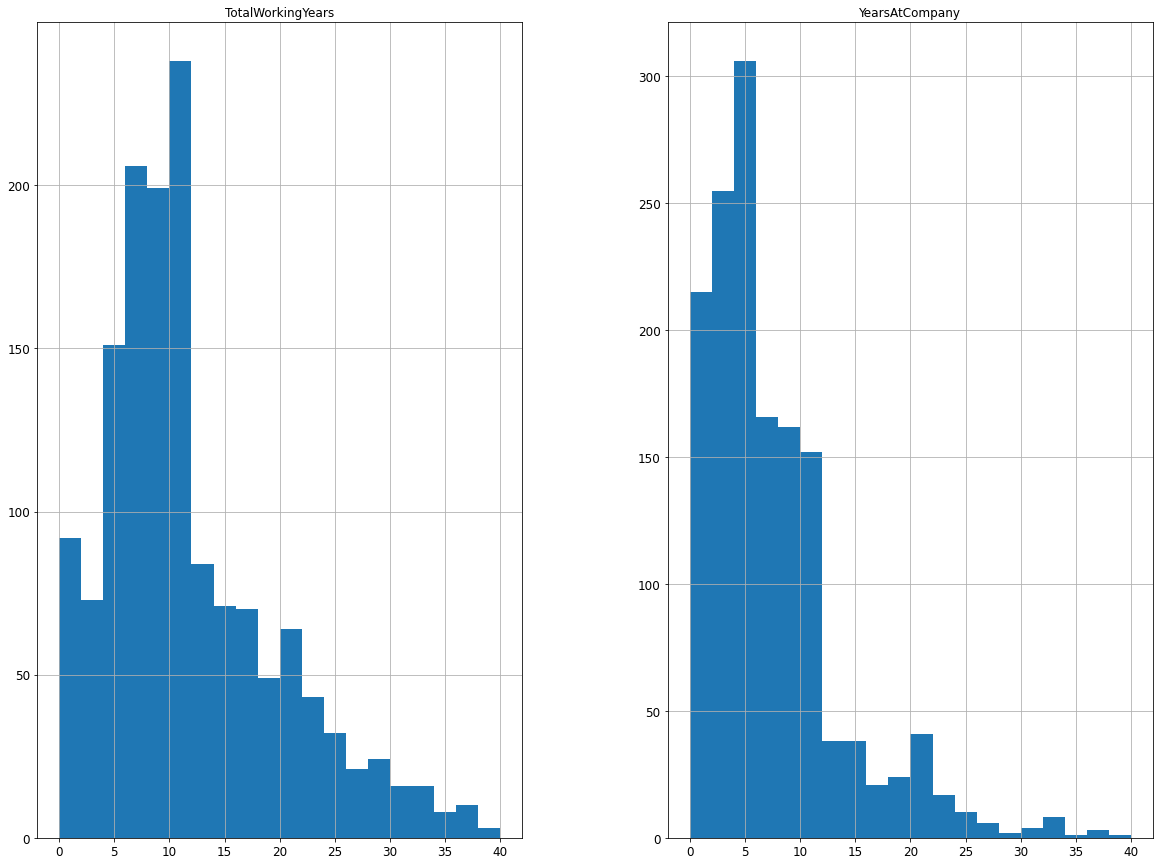

In [36]:
df[['YearsAtCompany', 'TotalWorkingYears']].hist(bins=20, figsize=(20,15))
plt.show()

In [37]:
df['YearsAtCompany'].value_counts()

5     196
1     171
3     128
2     127
10    120
4     110
7      90
9      82
8      80
6      76
0      44
11     32
20     27
13     24
15     20
14     18
22     15
12     14
21     14
18     13
16     12
19     11
17      9
24      6
33      5
25      4
26      4
31      3
32      3
36      2
27      2
29      2
23      2
30      1
34      1
37      1
40      1
Name: YearsAtCompany, dtype: int64

In [38]:
df['TotalWorkingYears'].value_counts()

10    202
6     125
8     103
9      96
5      88
1      81
7      81
4      63
12     48
3      42
15     40
16     37
13     36
11     36
21     34
17     33
14     31
2      31
20     30
18     27
19     22
23     22
22     21
24     18
25     14
28     14
26     14
0      11
29     10
31      9
32      9
27      7
30      7
33      7
36      6
34      5
37      4
35      3
40      2
38      1
Name: TotalWorkingYears, dtype: int64

For each of these variables, we remove observations that have >30 years as there are few of those observations in both categories.

In [39]:
df_filter = df[df['TotalWorkingYears'] < 30]
df_filter = df_filter[df_filter['YearsAtCompany'] < 30]

## Numerical Standardization

Finally the numerical variables must be standardized in order to conduct meaningful analysis.

In [40]:
df_num = []
cat_vars = ordinal_vars + ohe_vars + lab_vars
cat_vars.append('Attrition') # target variable
for i in list(df.columns):
    if i not in cat_vars:
        df_num.append(i)
        
df_num

['Age',
 'DailyRate',
 'DistanceFromHome',
 'EmployeeNumber',
 'HourlyRate',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([('scaler', StandardScaler())])
X_std = num_pipeline.fit_transform(df[df_num])
X_std

array([[ 0.4463504 ,  0.74252653, -1.01090934, ..., -0.0632959 ,
        -0.67914568,  0.24583399],
       [ 1.32236521, -1.2977746 , -0.14714972, ...,  0.76499762,
        -0.36871529,  0.80654148],
       [ 0.008343  ,  1.41436324, -0.88751511, ..., -1.16768726,
        -0.67914568, -1.15593471],
       ...,
       [-1.08667552, -1.60518328, -0.64072665, ..., -0.61549158,
        -0.67914568, -0.31487349],
       [ 1.32236521,  0.54667746, -0.88751511, ...,  0.48889978,
        -0.67914568,  1.08689522],
       [-0.32016256, -0.43256792, -0.14714972, ..., -0.33939374,
        -0.36871529, -0.59522723]])